In [77]:
import torch
import pandas as pd
import numpy as np

In [7]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(500, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 500),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [3]:
df = pd.read_csv('data/data.csv')
df = df.apply(pd.to_numeric, errors='coerce').fillna(0)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
data = df.drop(df.columns[:20], axis=1)
y = df[df.columns[3:20]]

In [15]:
X = torch.tensor(data.values, dtype=torch.float32)

In [65]:
encoder = AE()
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(encoder.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-8)


In [17]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
X_train, X_test, y_train, y_test = train_test_split(X, torch.tensor(y.values, dtype=torch.float32), test_size=0.4, random_state=42)

In [23]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [68]:
def train_encoder():
    min_loss = 1000
    encoder.train()
    losses = []
    outputs = []
    patience = 0
    while True:
        for i, _ in train_loader:
            reconstruct = encoder(i)
            loss = loss_function(reconstruct, i)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            if(loss.item() < min_loss):
                min_loss = loss.item()
            else:
                patience += 1
                if patience == 20:
                    return losses
        outputs.append((10, i, reconstruct))

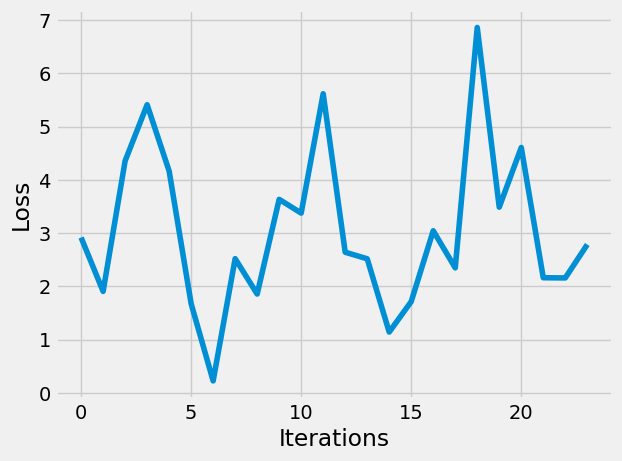

In [69]:
import matplotlib.pyplot as plt
losses = train_encoder()
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Plotting the last 100 values
plt.plot(losses[-100:])

In [35]:
losses[-1]

0.024000000208616257

In [90]:
import torch.nn as nn
import torch.nn.functional as F

class NNModel(nn.Module):
    def __init__(self, input_size=100, out_features=5):
        super(NNModel, self).__init__()
        self.fc1 = nn.Linear(in_features=input_size, out_features=20)
        self.bn1 = nn.BatchNorm1d(20)
        self.fc2 = nn.Linear(in_features=20, out_features=20)
        self.bn2 = nn.BatchNorm1d(20)
        self.fc3 = nn.Linear(in_features=20, out_features=out_features)
        self.dropout = nn.Dropout(0.0)  # Example dropout, adjust the rate as needed

    def forward(self, x):
        x = self.dropout(F.relu(self.bn1(self.fc1(x))))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.fc3(x))  # ReLU activation at the output layer
        return x


In [37]:
class MeanSquaredLogarithmicError(nn.Module):
    def __init__(self):
        super(MeanSquaredLogarithmicError, self).__init__()

    def forward(self, y_pred, y_true):
        y_pred = torch.clamp(y_pred, min=0)
        y_true = torch.clamp(y_true, min=0)
        
        return torch.mean((torch.log1p(y_true) - torch.log1p(y_pred)) ** 2)


In [38]:
import torch.optim as optim

In [162]:
#model = NNModel(9, 17)
criterion = MeanSquaredLogarithmicError()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-8)

In [163]:
from sklearn.model_selection import KFold
encoder.eval()
def train_model():
    model.train()
    # Assuming you have your dataset X, y
    kf = KFold(n_splits=5) # Example of 5-fold cross-validation
    patience = 0
    best_loss = 5*[100000]
    while True:
        
        for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
            print(f'Fold {fold+1}')

            X_t, X_val = X_train[train_index], X_train[val_index]
            y_t, y_v = y_train[train_index], y_train[val_index]

            for epoch in range(5):  # 100 epochs
                optimizer.zero_grad()
                
                outputs = model(encoder.encoder(X_t))
                loss = criterion(outputs, y_t)
                loss.backward()
                optimizer.step()
                
                # Validation step
                with torch.no_grad():
                    val_outputs = model(encoder.encoder(X_val))
                    val_loss = criterion(val_outputs, y_v)

                print(f'[{epoch + 1}] Training loss: {loss.item():.5f}, Validation loss: {val_loss.item():.5f}')
                if val_loss.item() < best_loss[fold]:
                    best_loss[fold] = val_loss.item()
                    patience = 0
                elif val_loss.item() > best_loss[fold]: 
                    patience += 1
                    if patience == 50:
                        print(f'Finished training with best val loss of {best_loss}')
                        return

            print('Finished Training for Fold', fold+1)
train_model()
   

Fold 1
[1] Training loss: 0.22139, Validation loss: 0.15495
[2] Training loss: 0.22113, Validation loss: 0.15497
[3] Training loss: 0.22089, Validation loss: 0.15499
[4] Training loss: 0.22066, Validation loss: 0.15502
[5] Training loss: 0.22046, Validation loss: 0.15505
Finished Training for Fold 1
Fold 2
[1] Training loss: 0.23534, Validation loss: 0.34174
[2] Training loss: 0.23531, Validation loss: 0.34150
[3] Training loss: 0.23527, Validation loss: 0.34126
[4] Training loss: 0.23522, Validation loss: 0.34103
[5] Training loss: 0.23515, Validation loss: 0.34082
Finished Training for Fold 2
Fold 3
[1] Training loss: 0.23063, Validation loss: 0.09676
[2] Training loss: 0.23057, Validation loss: 0.09640
[3] Training loss: 0.23051, Validation loss: 0.09605
[4] Training loss: 0.23045, Validation loss: 0.09572
[5] Training loss: 0.23040, Validation loss: 0.09541
Finished Training for Fold 3
Fold 4
[1] Training loss: 0.11477, Validation loss: 0.58798
[2] Training loss: 0.11461, Validatio

In [49]:
model.eval()
model.encoder(X_train[0])

tensor([-4166.7998,  5983.4922,  2386.8806, -5036.3882, -1504.5848, -5358.5151,
         8057.4048, -3305.3721,  3258.9795], grad_fn=<ViewBackward0>)

In [164]:
model.eval()
all_predictions = []
all_labels = []
with torch.no_grad():  # Disable gradient computation
    
    outputs = model(torch.tensor(encoder.encoder(X_test), dtype=torch.float32))
        




/var/folders/nb/x8ft0wb94sd72p6bpk_ld9fc0000gn/T/ipykernel_1573/2212870831.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(encoder.encoder(X_test), dtype=torch.float32))


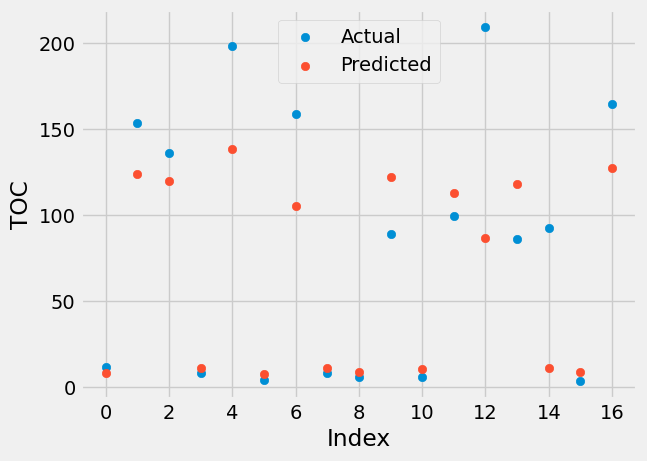

In [165]:
n = 16
plt.scatter([x for x in range(y_test.shape[0])], y_test[:,n], label='Actual')
plt.scatter([x for x in range(y_test.shape[0])], outputs[:,n], label='Predicted')
plt.xlabel('Index')
plt.ylabel(df.columns[n+3])
plt.legend()
plt.show()

Text(0.5, 1.0, 'TOC RMSE : 44.134229348605515')

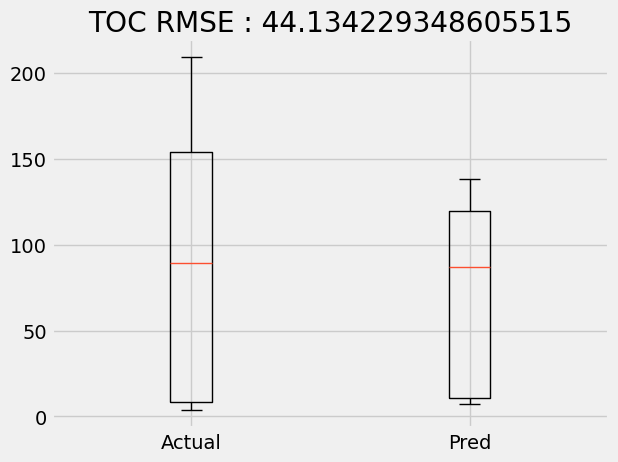

In [166]:
n=16
plt.boxplot([y_test[:,n], outputs[:,n]], labels=['Actual', 'Pred'])
loss = torch.nn.MSELoss()
plt.title(f'{df.columns[n+3]} RMSE : {np.sqrt(loss(y_test[:,n], outputs[:,n]).item())}')
